# Gaussian distributions: p-values and trials factors

### Goals:

1. To take a real scientific example of a Gaussian distribution: the weekly fluctuations of the observed Gamma-ray flux from the Vela pulsar.
2. To wonder and marvel at the fact that there is such a thing as the Gamma-ray pulsars.
3. To use our understanding of Gaussian and p-values to decide if we are seeing "flaring episodes" from the Vela pulsar, or just expected statistical fluctuations.
4. To compare the example of the Vela pulsar to an unidentified object in the Gamma-ray sky and decide if it had a "flaring episode".

### Timing

1. Try to finish this notebook in 30-35 minutes.  


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import datetime

plt.rcParams['font.size'] = 14

### New functions we will use in this module

| Function Name            | What it does |
| - | - |
|    datetime.datetime.fromtimestamp  | Converts time from seconds since a reference to a format with year, month, day, etc..., which matplotlib uses to make nice plot axis labels |
|    np.argmax             | Find the index of the largest element in an array  |


# Fermi Gamma-ray Space Telescope

The Fermi Gamma-ray Space Telescope is a NASA mission that was launched in 2008 and has spent the last 13 years observing the sky in gamma-rays.  You can read more about the Fermi mission on the NASA website:  https://fermi.gsfc.nasa.gov/

This is a map of the whole sky as seen by Fermi.  The map is in "Galactic Coordinates", looking out from the Earth.  The plane of the Galaxy (i.e., the Milky Way) runs horizontally across the map.  The center of the Galaxy (which lies in the constellation of Sagittarius) is at the center of the map.  As you can see from the bright band across the middle of the image, the Galaxy glows very brightly in Gamma Rays. 

If you look carefully at the map, you might notice that the point sources have some spatial extent to them. In all but a very few cases, that is because of the imperfect resolution of the instrument, not the intrinsic extension of the source. 

![Fermi sky map](figures/intens_ait_144m_gt1000_psf3_gal_0p1.png)

# The Vela Pulsar

There is a bright spot close to the Galactic Plane, about halfway between the center of the image and the right edge.  That is the Vela Pulsar.  Although it is hard to see in this image, where the color scale has been adjusted to highlight all the dimmer sources in the sky, the Vela Pulsar is by far the brightest object in the Gamma-ray sky.

The Vela pulsar is a neutron star left over from a supernova that occurred about 11 to 12 thousand years ago.  You can read about it here.

https://en.wikipedia.org/wiki/Vela_Pulsar

# Time Analysis: Light curves 

One important part of the Fermi scientific mission is to monitor objects in the sky for changes.  It turns out that many of the objects that produce gamma-rays are extremely variable in brightness.  They can flare up to hundreds of times their average brightness in a matter of hours or days.  

By design, the Fermi mission tries to observe each part of the sky the same amount of time each week.  For a variety of reasons it doesn't always work out that way.  So, to search for flaring episodes, they use a method where they compare the number of gamma-rays observed from a given source each week to a model that tells them how many gamma-rays to expect from that source.

We will be using some of these data, which were obtained from the publically available variability monitoring data here:

https://fermi.gsfc.nasa.gov/ssc/data/access/lat/FAVA/



In [2]:
data = np.loadtxt(open("../data/Vela_Flux.txt", 'rb'), usecols=range(7))

## This is how we pull out the data from columns in the array.

## This is the date in "Mission Elapsed Time" For the Fermi mission, this 
## is defined to be the number of seconds since the start of 2001.
date_MET = data[:,0]

## This is the offset in seconds between the Fermi "MET" and the UNIX 
## "epoch" used by matplotlib
MET_To_Unix = 978336000

## These are the number of photons observed from Vela each week in 
## the "low" Energy Band (100 MeV - 800 MeV)
nObs_LE = data[:,1]

## These are the number of photons expected from Vela each week, under 
## the assumption that it is not varying at all, and the only differences 
## depend on how long we spent looking at Vela that particular weeek
nExp_LE = data[:,2]

## These are the band bounds, in MeV
LE_bounds = (100., 800.)

## You could also take a look at data in the "high" energy band 
## (800 MeV - 10000 MeV), although that's not part of the lab this week.
#nObs_HE = data[:,4]
#nExp_HE = data[:,5]
#signif_HE = data[:6]
#HE_bounds = (800., 10000.)

# This converts the dates to something that matplotlib understands
dates = [datetime.datetime.fromtimestamp(date + MET_To_Unix) for date in date_MET]


Ok, lets plot the number of observed and expected gamma-rays seen from Vela each week.

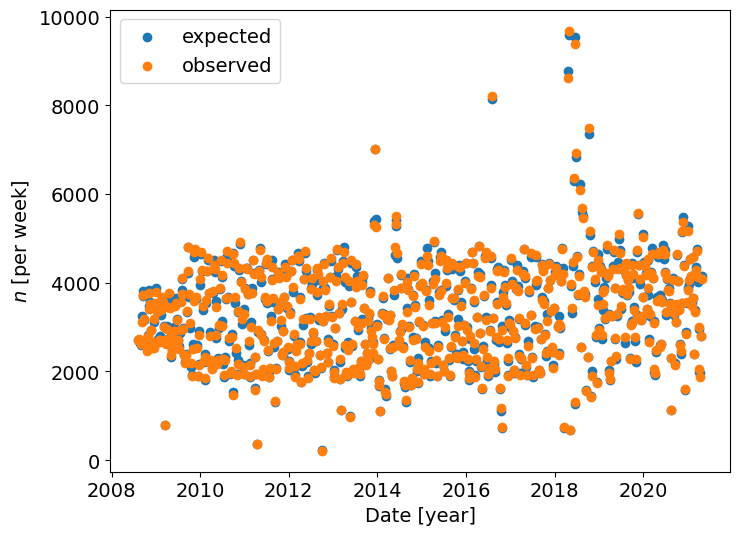

In [3]:
## Instantiate a figure and axis object for more control
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(dates, nExp_LE, label="expected")
ax.scatter(dates, nObs_LE, label="observed")
ax.set_ylabel(r"$n$ [per week]")
ax.set_xlabel("Date [year]")

ax.legend()
plt.show()

It looks like the observed data points are pretty close to the expected data points, let's check that by making a scatter plot.

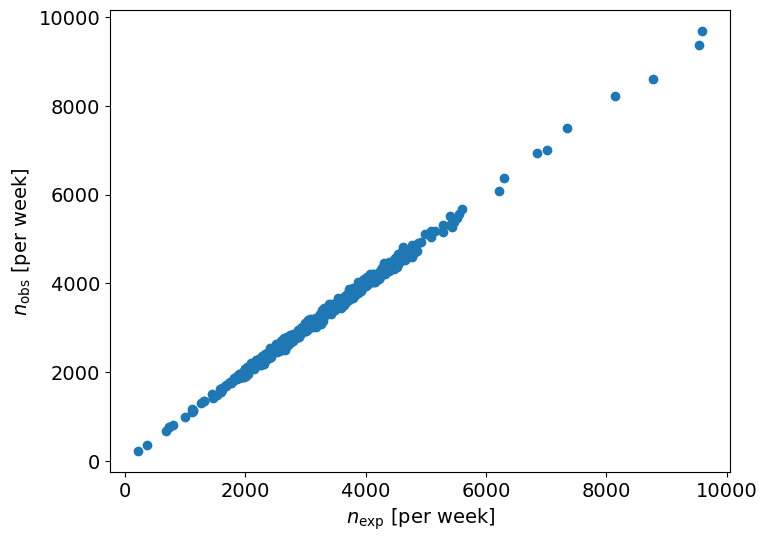

In [4]:
## Instantiate a figure and axis object for more control
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(nExp_LE, nObs_LE)
ax.set_xlabel(r"$n_{\rm exp}$ [per week]")
ax.set_ylabel(r"$n_{\rm obs}$ [per week]")

plt.show()

Yep, they seem highly correlated.  Now let's look at the difference between the observed and expected events and see if anything sticks out.

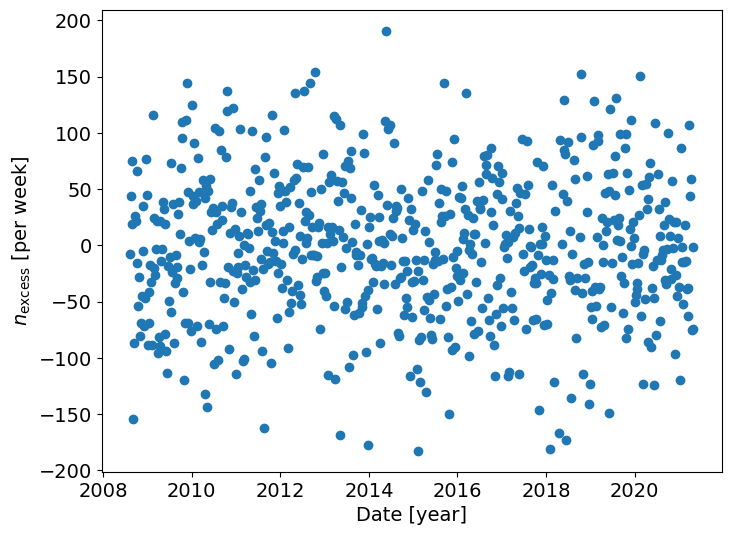

In [5]:
## Instantiate a figure and axis object for more control
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(dates, nObs_LE-nExp_LE)
ax.set_ylabel(r"$n_{\rm excess}$ [per week]")
ax.set_xlabel("Date [year]")

plt.show()

Hmm. Looks pretty random, but it is kind of hard to tell because we don't really know what kind of scatter to expect.  That point up around 200 might be interesting.

Now, let's recall that the number of events observed is a random process that can be described by a Gaussian where the width is $\sigma = \sqrt{n}$, when the rate is large.  

So we are going to divide the excess for each week by the expected statistical fluctation for that week to get a sense of how significant the outliers might be.

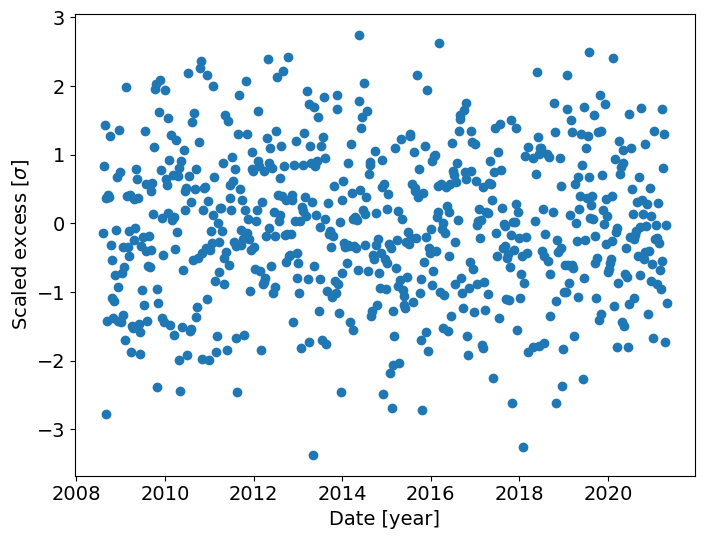

In [6]:
sigma_nObs_LE = np.sqrt(nObs_LE)
scaled_residuals = (nObs_LE-nExp_LE)/sigma_nObs_LE

## Instantiate a figure and axis object for more control
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(dates, scaled_residuals)
ax.set_ylabel(r"Scaled excess [$\sigma$]")
ax.set_xlabel("Date [year]")

plt.show()

And let's make a histogram of the y-axis values and see if it really looks like a Gaussian.

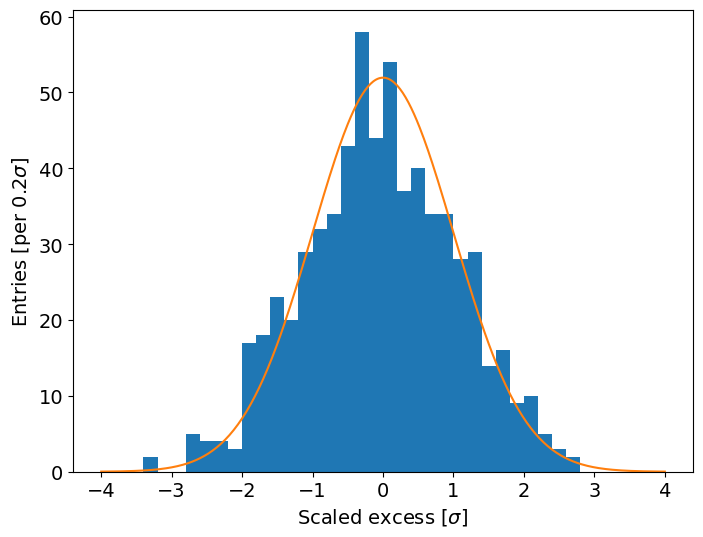

In [7]:
## Generate some Gaussian values to compare to
nWeeks = len(nObs_LE)
myGauss = nWeeks*0.2*stats.norm(loc=0, scale=1).pdf(np.linspace(-4,4,401))

## Instantiate a figure and axis object for more control
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.hist(scaled_residuals, bins=np.linspace(-4,4,41))
ax.plot(np.linspace(-4,4,401), myGauss)
ax.set_xlabel(r"Scaled excess [$\sigma$]")
ax.set_ylabel(r"Entries [per $0.2 \sigma$]")

plt.show()

### Interpretation in terms of p-values

Ok, those data look pretty Gaussian.  Let's take a look at the largest outliers and see how significant they are.

In [8]:
max_value = np.max(scaled_residuals)
p_value = stats.norm(loc=0, scale=1).sf(max_value)
print(f"The largest scaled excess is {max_value:0.2f} sigma")
print(f"The corresponding p-value is {p_value:0.5f}")
print(f"That corresponds to a 1 in {(1/p_value):0.0f} chance of occuring randomly")

The largest scaled excess is 2.75 sigma
The corresponding p-value is 0.00299
That corresponds to a 1 in 334 chance of occuring randomly


### Questions for discussion.

#### 4.1 A 1 in 334 chance of occuring naturally seems really unlikely.  However the distribution of scaled residual looks pretty Gaussian, and the scatter plot above looks pretty random;  what is going on? Why does it make sense that the largest scaled residual is about 2.75 sigma even if the data are distributed randomly?  Why wouldn't we consider this to be a really flaring episode?  (Use numbers to back up your explanations.)

#### 4.2 Given the way that analysis was done, and that we have observed for 651 weeks, what level of statistical significance might we want to use as a threshold for a flaring episode?

## Unidentifed flaring object.

Now let's take the data for a different object.  In fact, I picked a very faint object for which, when we average the data out over 12 years, it is hard to even tell if there is anything there or not.

In [9]:
unid_data = np.loadtxt(open("../data/UNID_Flux.txt", 'rb'), usecols=range(7))
unid_date_MET = unid_data[:,0]
unid_nObs_LE = unid_data[:,1]
unid_nExp_LE = unid_data[:,2]
unid_signif_LE = unid_data[:,3]
unid_dates = [datetime.datetime.fromtimestamp(date + MET_To_Unix) for date in unid_date_MET]
unid_sigma_nObs_LE = np.sqrt(unid_nObs_LE)

#### Excess counts with error bars.

First, let's make a slightly different version of the plots we made above.  
This time we will plot the excess counts, and use the $\sqrt{n}$ as the error bars.

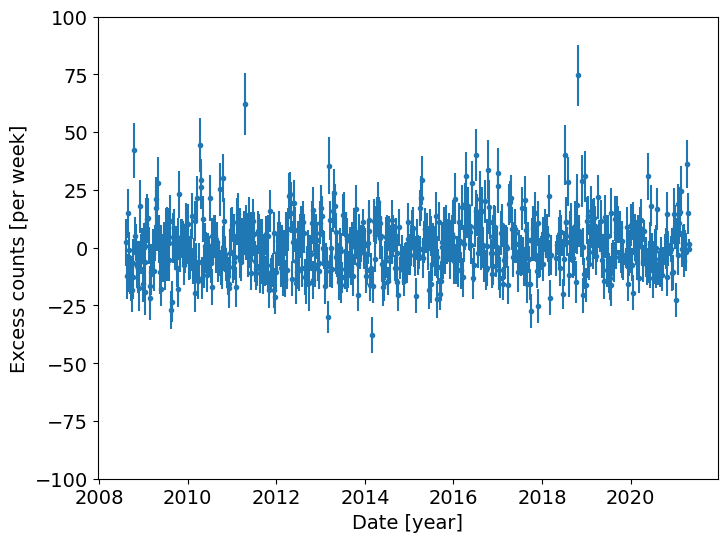

In [10]:
## Instantiate a figure and axis object for more control
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.errorbar(unid_dates, unid_nObs_LE-unid_nExp_LE, yerr=unid_sigma_nObs_LE, fmt='.')
ax.set_ylim(-100, 100)
ax.set_ylabel("Excess counts [per week]")
ax.set_xlabel("Date [year]")

plt.show()

### Interpretation in terms of p-values:

A few of those points look pretty significant.  Let's quantify them in terms of their p-values.

First, let's plot the scaled excess. We'll take this quantity directly from the Fermi data, which does an analysis which is a bit more complex than simply dividing the excess counts by $\sqrt{n}$.

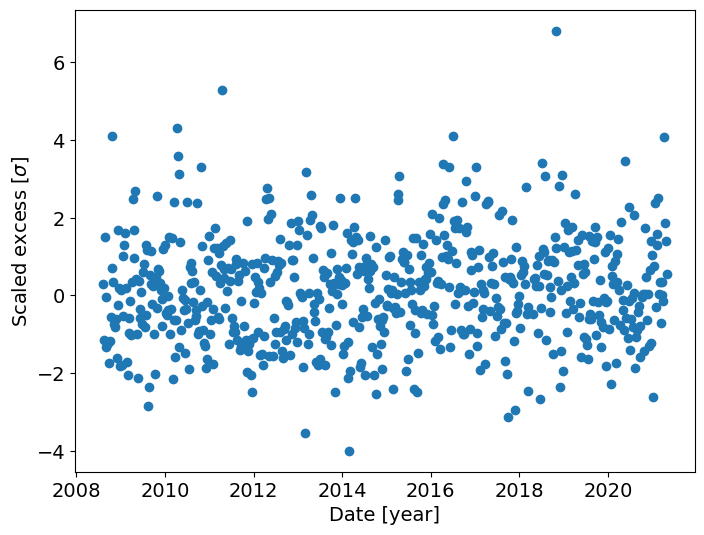

In [11]:
## Instantiate a figure and axis object for more control
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.scatter(unid_dates, unid_signif_LE)
ax.set_ylabel(r"Scaled excess [$\sigma$]")
ax.set_xlabel("Date [year]")

plt.show()

Now let's make a histogram of the scaled excess and see if it looks Gaussian.

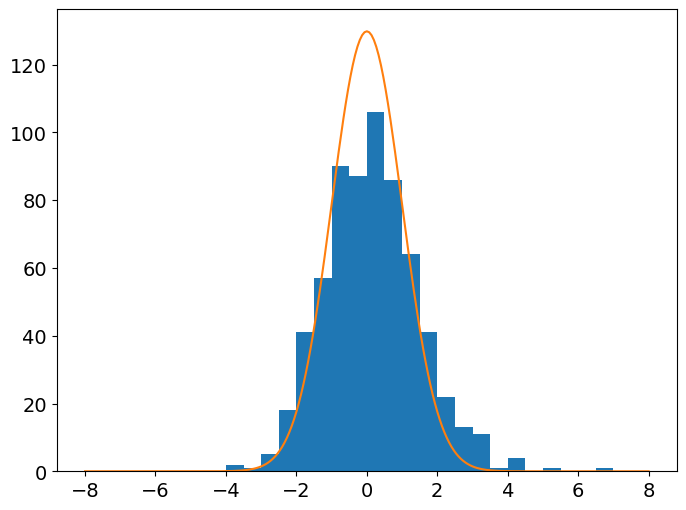

In [12]:
myGauss = len(unid_signif_LE)*0.5*stats.norm(loc=0, scale=1).pdf(np.linspace(-8,8,241))

## Instantiate a figure and axis object for more control
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.hist(unid_signif_LE, bins=np.linspace(-8, 8, 33))
ax.plot(np.linspace(-8,8,241), myGauss)

plt.show()

Well, it looks pretty Gaussian, but there are definitely a few outliers at the > 4 sigma level, and maybe a slight excess of weeks at the 2-3 sigma level.  Let's follow up on the largest outlier.

In [13]:
max_value_unid = np.max(unid_signif_LE)
p_value_unid = stats.norm(loc=0, scale=1).sf(max_value_unid)

print(f"The largest scaled excess is {max_value_unid:0.2f} sigma")
print(f"The corresponding p-value is {p_value_unid:0.2e}")
print(f"That corresponds to a 1 in {(1/p_value_unid):0.0e} chance of occuring randomly")

The largest scaled excess is 6.81 sigma
The corresponding p-value is 4.73e-12
That corresponds to a 1 in 2e+11 chance of occuring randomly


Ok, it seems pretty significant, let's print some information about it.

In [14]:
flare_index = np.argmax(unid_signif_LE)
flare_date = unid_dates[flare_index]

print(f"Flare detected in the week of {flare_date.strftime('%Y-%m-%d')} at the level of {max_value_unid:0.1f} sigma significance")

Flare detected in the week of 2018-10-26 at the level of 6.8 sigma significance


### Questions for discussion

#### 5.1 In contrast to the case for the Vela pulsar, here the chance for an outlier this size occurring randomly is tiny, even given the fact that we are considering over 600 weeks of data.  In fact we'd have to observe for something like $2 \times 10^{11}$ = 200 billion weeks to expect a random fluctuation of this size.  On the other hand, the change in significance only went from $2.75 \sigma$ to $6.81 \sigma$. Explain, in your own words, what this means in terms of how we should think about significance in terms of $\sigma$ as compared to significance in terms of p-values.  

#### 5.2 Does this change your opinions about the conventions used to define statistical significance?  If someone reports a result with a p-value of $p < 0.05$ what are some follow up questions you might ask them?
